In [1]:
from model import Network
from data import load_cifar10_dataloaders, WhiteningTransformation
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from criterion import ReconstructImageFromFCLoss
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from metrics import lpips, psnr

# reproducibility
random_seed = 2024

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(random_seed)

In [2]:
# load to model
model_config = './model_config/fc1_cocktail_party_cifar10_instance.json'
checkpoint_path = './checkpoints/122123_fc1_cocktail_party_cifar10_pretraining_wout_bias_wout_normalization.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Network(model_config)
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])
model = model.to(device)

# get val loader
batch_size = 4
data_path = './data'
transform = transforms.Compose([
    transforms.ToTensor(),
])

_, val_dataloader = load_cifar10_dataloaders(data_path, batch_size, transform)
selected_val_batch_data, selected_val_batch_label = next(iter(val_dataloader))
selected_val_batch_data = selected_val_batch_data.to(device)
selected_val_batch_label = selected_val_batch_label.to(device)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# receiving gradients
model.zero_grad()
criterion = nn.CrossEntropyLoss()
output = model(selected_val_batch_data.reshape(batch_size, -1))
loss = criterion(output, selected_val_batch_label)
loss.backward()
gradient_of_layers = []
for param in model.parameters():
    gradient_of_layers.append(param.grad.data.clone().to('cpu'))
print([x.size() for x in gradient_of_layers])

[torch.Size([10, 3072])]


In [4]:
whitening_transform = WhiteningTransformation()
whitened_gradient = torch.from_numpy(whitening_transform.transform(gradient_of_layers[0].detach().numpy().T)).to(torch.float32).T
whitened_gradient = whitened_gradient.to(device)

In [5]:
# criterion output testing
unmixing_matrix = torch.rand((selected_val_batch_data.size(0), gradient_of_layers[0].size(0)), requires_grad=True, device=device)
reconstruction_loss = ReconstructImageFromFCLoss(32, 32, 3, 0.5268346884538906, 7.415861546208221, 4.910887792883931)
optimizer = torch.optim.Adam([unmixing_matrix])

for iter_idx in range(25000):
    optimizer.zero_grad()
    # out_score, non_gaussianity_score, total_variance_score, mutual_independence_score
    loss, _, _, _ = reconstruction_loss(unmixing_matrix, whitened_gradient)
    loss.backward()
    optimizer.step()
    
    if (iter_idx + 1) % 1000 == 0 or iter_idx == 0:
        print('loss: {}'.format(loss.item()))

loss: 7.846158027648926
loss: 5.1722002029418945
loss: 5.044954776763916
loss: 5.001115798950195
loss: 4.97650671005249
loss: 4.963996410369873
loss: 4.953238010406494
loss: 4.950048923492432
loss: 4.946357250213623
loss: 4.944632530212402
loss: 4.942262649536133
loss: 4.941235542297363
loss: 4.942996501922607
loss: 4.940132141113281
loss: 4.9371418952941895
loss: 4.935676097869873
loss: 4.936235427856445
loss: 4.937564373016357
loss: 4.930689334869385
loss: 4.932063102722168
loss: 4.931286811828613
loss: 4.938221454620361
loss: 4.931186199188232
loss: 4.930298328399658
loss: 4.935252666473389
loss: 4.929645538330078


In [6]:
unmixing_matrix = unmixing_matrix.detach().to('cpu')
whitened_gradient = whitened_gradient.detach().to('cpu')

## PSNR Values

In [9]:
with torch.no_grad():
    psnr_match, psnr_is_positive, mean_psnr = psnr(unmixing_matrix @ whitened_gradient, selected_val_batch_data.detach().to('cpu'), return_matches=True)

In [10]:
psnr_match

[tensor([2, 1]), tensor([0, 3]), tensor([3, 2]), tensor([1, 0])]

In [11]:
mean_psnr

9.648099660873413

In [12]:
psnr_is_positive

[True, True, False, True]

## LPIPS

In [13]:
with torch.no_grad():
    lpips_match, lpips_is_positive, mean_lpips = lpips(unmixing_matrix @ whitened_gradient, selected_val_batch_data.detach().to('cpu'), return_matches=True)

In [14]:
lpips_match

[tensor([2, 3]), tensor([0, 2]), tensor([3, 0]), tensor([1, 1])]

In [15]:
mean_lpips

0.05717747285962105

In [16]:
lpips_is_positive

[False, False, False, False]

## Estimated images

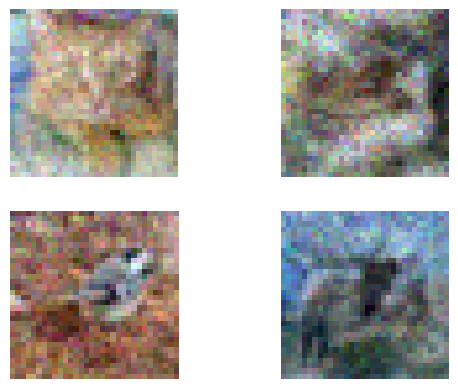

In [20]:
with torch.no_grad():
    estimated_img = (unmixing_matrix @ whitened_gradient)
    
    fig, axes = plt.subplots(2, 2)
    
    for estimate, ax, is_positive in zip(estimated_img, axes.flatten(), lpips_is_positive):
        estimate_coeff = 1 if is_positive else -1
        img = colors.Normalize()(np.asarray(estimate_coeff * estimate).reshape(3, 32, 32).transpose(1, 2, 0))
        ax.imshow(img)
        ax.axis('off')
    plt.show()

## Original images

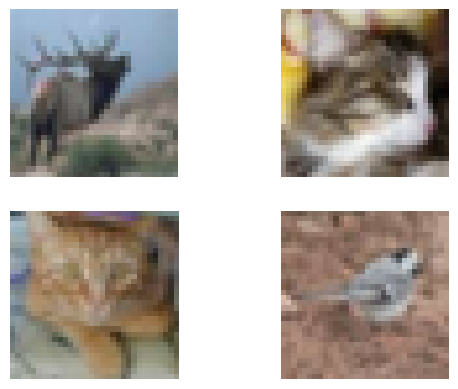

In [21]:
with torch.no_grad():
    fig, axes = plt.subplots(2, 2)
    
    for estimate, ax in zip(selected_val_batch_data, axes.flatten()):
        img = transforms.ToPILImage()(estimate.reshape(3, 32, 32))
        img = np.asarray(img)
        ax.imshow(img)
        ax.axis('off')
    plt.show()